# Pertanyaan penelitian

Pada kesempatan kali ini, saya ingin mengetahui bagaimana perkembangan kasus baru pada tanggal 1 - 14 Des 2021 di Indonesia. Jika diasumsikan tidak adanya outbreak mendadak dan masuknya varian baru apakah kasusnya bisa menurun dan sejauh apa menurunnya.

Data yang diolah adalah data Covid-19 di Indonesia yang diambil dari situs kawalcovid19. Data diambil dari tanggal 1 Juni 2021 - 30 November 2021. Saya akan mencoba melakukan *forecasting* dengan menerapkan metode *polynomial regression*.

# 1. Data Collection

Disini kita akan mencoba untuk mengumpulkan data yang dibutuhkan.

In [1]:
# import semua package/library pada sel ini
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics

In [9]:
# pemanggilan data dalam bentuk dataframe, dan ditampilkan dengan metode head
df = pd.read_csv('covid.csv',sep=";")
df.head()

,Tanggal,Kasus_harian,Total_kasus,Kasus_aktif,Sembuh_baru,Sembuh,Meninggal_baru,Meninggal_Dunia
0,2021-06-01,4824,1826527,101325,5360,1674479,145,50723
1,2021-06-02,5246,1831773,100364,6022,1680501,185,50908
2,2021-06-03,5353,1837126,94438,11092,1691593,187,51095
3,2021-06-04,6486,1843612,94773,5950,1697543,201,51296
4,2021-06-05,6594,1850206,96973,4241,1701784,153,51449


# 2. Data Preparation

Pada langkah ini kita akan menyiapkan data yang dibutuhkan. Karena kita akan memprediksi total kasus pada periode tertentu, maka kolom yang digunakan adalah Kolom Tanggal dan Kasus harian.

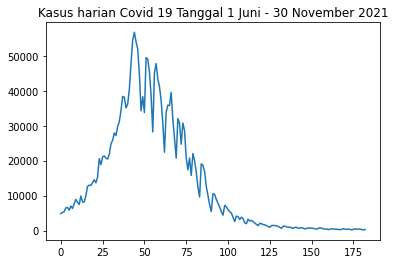

In [20]:
# Grafik kasus harian
df['Kasus_harian'].plot.line()
plt.title("Kasus harian Covid 19 Tanggal 1 Juni - 30 November 2021")
plt.tight_layout;

In [4]:
# melihat detail dari dataset
df.describe()

,Kasus_harian,Total_kasus,Kasus_aktif,Sembuh_baru,Sembuh,Meninggal_baru,Meninggal_Dunia
count,183.000000,1.830000e+02,183.000000,183.000000,1.830000e+02,183.000000,183.000000
mean,13304.404372,3.538384e+06,182504.644809,13308.950820,3.244209e+06,509.573770,111669.808743
std,15255.212616,8.886162e+05,185697.715237,14052.400064,9.348800e+05,570.624204,36197.288002
min,176.000000,1.826527e+06,7916.000000,260.000000,1.674479e+06,1.000000,50723.000000
25%,908.500000,2.806779e+06,19032.000000,1527.500000,2.218442e+06,43.500000,71943.000000
50%,6486.000000,4.089801e+06,109869.000000,7167.000000,3.760497e+06,237.000000,133023.000000
75%,21574.500000,4.233512e+06,322127.500000,22109.500000,4.071570e+06,880.000000,142911.000000
max,56757.000000,4.256409e+06,574135.000000,48832.000000,4.104657e+06,2069.000000,143830.000000


In [6]:
# mengecek tipe data dari semua kolom pada dataset
df.dtypes

Tanggal            object
Kasus_harian        int64
Total_kasus         int64
Kasus_aktif         int64
Sembuh_baru         int64
Sembuh              int64
Meninggal_baru      int64
Meninggal_Dunia     int64
dtype: object

Karena yang akan kita gunakan adalah kolom tanggal sebagai *time-series* dan kasus harian sebagai *input*. maka kita perhatikan dua kolom tersebut.

Pada detail kasus harian terlihat rentang nilai maksimum dan minimum yang sangat jauh dengan 50% data berada di angka 6000 an. jauh dari rata-rata yang berkisar 13000. Sehingga kita perlu melakukan normalisasi pada kolom tersebut. 

Lalu karena input data harus berbentuk angka, maka kita akan mengubah tanggal menjadi *numerik*.

In [10]:
'''pada kolom ini kita akan melakukan transformasi dan menambahkan kolom baru pada dataframe kita. 
Kita beri nama kolom baru dengan data hasil normalisasi tersebut sebagai cases_norm.
Normalisasi akan dilakukan dengan menggunakan metode logaritmik.
'''
df['Kasus_normalisasi'] = np.log(df['Kasus_harian'])
df

,Tanggal,Kasus_harian,Total_kasus,Kasus_aktif,Sembuh_baru,Sembuh,Meninggal_baru,Meninggal_Dunia,Kasus_normalisasi
0,2021-06-01,4824,1826527,101325,5360,1674479,145,50723,8.481359
1,2021-06-02,5246,1831773,100364,6022,1680501,185,50908,8.565221
2,2021-06-03,5353,1837126,94438,11092,1691593,187,51095,8.585412
3,2021-06-04,6486,1843612,94773,5950,1697543,201,51296,8.777401
4,2021-06-05,6594,1850206,96973,4241,1701784,153,51449,8.793915
...,...,...,...,...,...,...,...,...,...
178,2021-11-26,453,4255268,8093,386,4103379,14,143796,6.115892
179,2021-11-27,404,4255672,8226,260,4103639,11,143807,6.001415
180,2021-11-28,264,4255936,8214,275,4103914,1,143808,5.575949
181,2021-11-29,176,4256112,7960,419,4104333,11,143819,5.170484


Setelah ini kita akan mengubah kolom tanggal menjadi kolom numerik dengan 1 Juni 2021 sebagai dasar. 
Artinya saya akan mengubah 

- 2021-06-01 menjadi 0, 
- 2021-06-02 menjadi 1,
- dst.

In [12]:
'''Dengan memanfaatkan metode to_datetime pada pandas kita akan mengubah row index 0 pada tanggal 
dan masukkan pada suatu variabel bernama Tanggal_pertama.
Nilai inilah yang akan menjadi nilai pengurang untuk tanggal lainnya
'''
df['Tanggal'] = pd.to_datetime(df['Tanggal'])
Tanggal_pertama = df.loc[0,'Tanggal']
print(f'Nilai Tanggal pertama adalah = {Tanggal_pertama}')

Nilai Tanggal pertama adalah = 2021-06-01 00:00:00


Sekarang kita akan membuat fungsi yang akan mengubah semua tanggal pada kolom menjadi numerik dengan basis pada tanggal 1 Juni 2021.

In [13]:
'''Pada kesempatan kali ini kita akan memanfaatkan apply() dan lambda().
Kita akan masukkan pada sebuah kolom baru bernama Hari ke-. lalu kita tampilkan dataframe terbaru
'''

df['Hari ke-'] = df['Tanggal'].apply(lambda x: pd.Timedelta(pd.to_datetime(x)-Tanggal_pertama).days)
df

,Tanggal,Kasus_harian,Total_kasus,Kasus_aktif,Sembuh_baru,Sembuh,Meninggal_baru,Meninggal_Dunia,Kasus_normalisasi,Hari ke-
0,2021-06-01,4824,1826527,101325,5360,1674479,145,50723,8.481359,0
1,2021-06-02,5246,1831773,100364,6022,1680501,185,50908,8.565221,1
2,2021-06-03,5353,1837126,94438,11092,1691593,187,51095,8.585412,2
3,2021-06-04,6486,1843612,94773,5950,1697543,201,51296,8.777401,3
4,2021-06-05,6594,1850206,96973,4241,1701784,153,51449,8.793915,4
...,...,...,...,...,...,...,...,...,...,...
178,2021-11-26,453,4255268,8093,386,4103379,14,143796,6.115892,178
179,2021-11-27,404,4255672,8226,260,4103639,11,143807,6.001415,179
180,2021-11-28,264,4255936,8214,275,4103914,1,143808,5.575949,180
181,2021-11-29,176,4256112,7960,419,4104333,11,143819,5.170484,181


Selanjutnya, kita akan membuat salinan dari data pada kolom Kasus_normalisasi dan Hari ke- ke dalam dataframe baru.

In [14]:
#isikan pada sel ini dataframe terbaru dan tampilkan
df_actual = df[['Kasus_normalisasi','Hari ke-']]
df_actual

,Kasus_normalisasi,Hari ke-
0,8.481359,0
1,8.565221,1
2,8.585412,2
3,8.777401,3
4,8.793915,4
...,...,...
178,6.115892,178
179,6.001415,179
180,5.575949,180
181,5.170484,181


# 3. Data Processing

Sekarang kita akan memproses data kita. Terdapat dua bagian, pertama adalah pembuatan model dan kedua adalah evaluasi sederhana.

In [22]:
#pembuatan model
'''
Pada bagian kali ini kita akan mengubah hari menjadi sumbu x dan kasus normalisasi ke dalam sumbu y.
Data akan diubah menjadi bentuk numpy array dengan np.array()
dan .reshape((-1, 1)) pada sumbu x saat mengubah menjadi np.array agar mengubah dimensi array tersebut.
kita bagi menjadi data training dan test dengan test_size = 0.2
'''
Sumbu_x = np.array(df_actual['Hari ke-']).reshape((-1,1))
Sumbu_y = np.array(df_actual['Kasus_normalisasi'])

X_train, X_test, y_train, y_test = train_test_split(Sumbu_x, Sumbu_y, random_state=72, test_size=0.2)

print(f'Dimensi dari X_train : {len(X_train)}')
print(f'Dimensi dari y_train : {len(y_train)}')
print(f'Dimensi dari X_test : {len(X_test)}')
print(f'Dimensi dari y_test : {len(y_test)}')

Dimensi dari X_train : 146
Dimensi dari y_train : 146
Dimensi dari X_test : 37
Dimensi dari y_test : 37


**Pembuatan model.** 

Fungsi yang akan digunakan adalah regresi karena kita ingin mencari hubungan terhadap 1 variabel independen. Karena data berbentuk fungsi kuadratik maka pendekatan yang digunakan adalah *polynomial regression*.

Sehingga model linear regression kita akan diubah ke dalam bentuk polinomial.

In [23]:
'''Import modul PolynomialFeatures dari sklearn.preprocessing
Dan modul linear regression dari sklearn
'''

poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(X_train)

model_l = LinearRegression()
model_l.fit(X_poly, y_train)

LinearRegression()

Selanjutkan kita akan melakukan evaluasi model kita dengan membuat prediksi dari x_test kita lalu bandingkan hasilnya dengan y_test menggunakan nilai r_square.

In [41]:
# pertama, prediksikan seluruh data x_test.
# gunakan poly_reg.fit_transform untuk mengubah data menjadi bentuk polynomialnya
poly_x_test = poly_reg.fit_transform(X_test)

#setelah itu  buat variabel y_pred dengan menggunakan metode predict dan tampilkan y_pred
y_pred = model_l.predict(poly_x_test)
y_pred

array([9.17978982, 9.90803094, 6.46774874, 6.93038075, 4.51080569,
       7.94087955, 9.84012179, 8.48579512, 9.62683251, 9.45148837,
       9.8482902 , 8.84496331, 9.90700306, 9.60387663, 4.8068148 ,
       9.55411897, 9.86306185, 7.25544257, 5.09447641, 9.80223099,
       9.53463629, 9.49410577, 8.32751973, 5.77711014, 9.85822633,
       9.89086091, 9.58579557, 9.90127972, 9.90209737, 9.4293971 ,
       5.57779807, 9.68645614, 7.35962276, 9.20709828, 9.82221983,
       9.85593688, 6.76080664])

In [42]:
# evaluasi model
r2 = metrics.r2_score(y_test, y_pred)

print("Performa model untuk data uji")
print("--------------------------------------")
print('R2 score is {}'.format(r2))

Performa model untuk data uji
--------------------------------------
R2 score is 0.8881566854226721


Nilai r square sebesar 0.88 adalah hasil yang baik, ini menunjukkan bahwa model yang digunakan dapat memprediksi jumlah kasus Covid.

Karena kita ingin memprediksi data kita 14 hari semenjak data terakhir maka dibuatlah numpy array dari 183 - 196

In [26]:
# membuat variabel numpy array denan nama variabel predict_date
predict_date = np.arange(183,197).reshape(-1,1)
predict_date

array([[183],
       [184],
       [185],
       [186],
       [187],
       [188],
       [189],
       [190],
       [191],
       [192],
       [193],
       [194],
       [195],
       [196]])

In [46]:
# Melakukan prediksi pada variabel predict_date memanfaatkan kembali poly_reg.fit_transform dan pol_reg.predict.
# Lalu disimpan dengan nama variabel predict_cases

poly_x_test2 = poly_reg.fit_transform(predict_date)
predict_cases = model_l.predict(poly_x_test2)
predict_cases

array([4.43549911, 4.35967082, 4.28332081, 4.20644908, 4.12905563,
       4.05114046, 3.97270358, 3.89374497, 3.81426465, 3.73426261,
       3.65373885, 3.57269337, 3.49112617, 3.40903725])

# 4. Data Analysis

Pada kesempatan kali ini kita akan melakukan analisis pada grafik dan model kita.

In [47]:
# Hasil prediksi yang masih berbentuk logaritmik akan diubah kembali menggunakan fungsi eksponensial
predict_cases = [int(np.exp(x)) for x in predict_cases]
print("Prediksi kasus harian", predict_cases)

Prediksi kasus harian [84, 78, 72, 67, 62, 57, 53, 49, 45, 41, 38, 35, 32, 30]


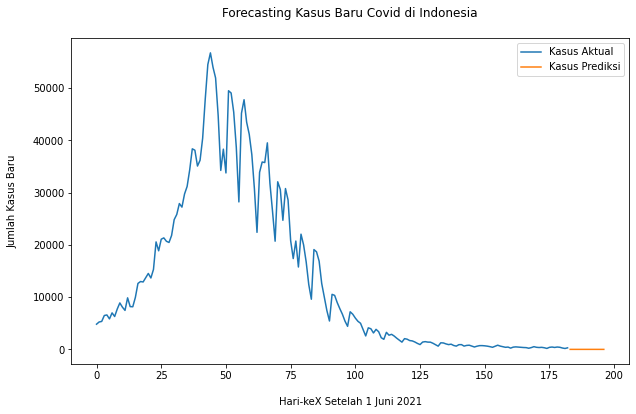

In [39]:
# Tampilan grafik
plt.figure(figsize=(10,6))
df['Kasus_harian'].plot.line(label='Kasus Aktual')
plt.plot(predict_date,predict_cases, label='Kasus Prediksi')
plt.title("Forecasting Kasus Baru Covid di Indonesia\n")
plt.xlabel("\nHari-keX Setelah 1 Juni 2021")
plt.ylabel("Jumlah Kasus Baru\n")
plt.legend()
plt.show()

**Analisis**

Diperkirakan jumlah kasus baru covid di Indonesia pada 1-14 Des 2021 (183 hari setelah 1 Juni) akan menurun tiap harinya mengikuti grafik kasus sebelumnya yang terbilang rendah dan terus menurun.

Prediksi ini memiliki asumsi bahwa tidak adanya *outbreak* mendadak dan masuknya varian baru.